In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid

#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, root_mean_squared_error, accuracy_score


### Read in data

In [7]:
train_df = pd.read_csv('data/train_imputed.csv', index_col=0)
test_df = pd.read_csv('data/test_imputed.csv', index_col=0)


In [9]:
subset_cols = [
    'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
   'Waterproof', 'Style', 'Color', 
]
train_df[train_df.duplicated(subset=subset_cols)].sort_values(by=subset_cols).head(20)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Brand_enc,Material_enc,Size_enc,Style_enc,Color_enc
181610,181610,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Black,12.934888,94.30610,0.0,0.0,0.0,0.0,0.0
186228,186228,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Black,6.764235,63.04050,0.0,0.0,0.0,0.0,0.0
234022,234022,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Black,22.926874,127.68648,0.0,0.0,0.0,0.0,0.0
198491,198491,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Blue,23.094200,107.26545,0.0,0.0,0.0,0.0,1.0
158355,158355,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Gray,6.842138,68.44083,0.0,0.0,0.0,0.0,2.0
176075,176075,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Gray,6.751033,99.23663,0.0,0.0,0.0,0.0,2.0
180685,180685,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Gray,5.000000,79.65638,0.0,0.0,0.0,0.0,2.0
212599,212599,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Gray,26.927667,150.00000,0.0,0.0,0.0,0.0,2.0
216948,216948,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Gray,28.535343,51.30692,0.0,0.0,0.0,0.0,2.0
238670,238670,Adidas,Canvas,Large,1.0,0.0,0.0,Backpack,Gray,24.576620,122.43889,0.0,0.0,0.0,0.0,2.0


In [10]:
train_df[train_df.duplicated(subset=subset_cols)].sort_values(by=subset_cols).to_csv('data/duplicates.csv')

In [56]:
def create_submission_file(sub_df):
    submission = pd.read_csv("data/sample_submission.csv")
    submission["Price"] = sub_df["price"]
    display(submission.head(2))
    file_name = datetime.now().strftime('submissions/submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

### Exploratory

In [57]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [58]:
test.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


From initial observation it looks like we will need to encode categorical variables, and binary encode yes no variables. There are also missing values that we should deal with, but there may be some patterns that can help us with that. 

### Duplicate Values

In [59]:
# find duplicates 
train.duplicated().sum()

0

In [60]:
test.duplicated().sum()

0

In [61]:
# just in case 
print(train.shape, test.shape)
train = train.drop_duplicates()
test = test.drop_duplicates()
print(train.shape, test.shape)

(300000, 11) (200000, 10)
(300000, 11) (200000, 10)


### Missing Values

In [62]:
train.isna().sum(axis=0) / train.shape[0]

id                      0.000000
Brand                   0.032350
Material                0.027823
Size                    0.021983
Compartments            0.000000
Laptop Compartment      0.024813
Waterproof              0.023500
Style                   0.026567
Color                   0.033167
Weight Capacity (kg)    0.000460
Price                   0.000000
dtype: float64

In [63]:
test.isna().sum(axis=0) / test.shape[0]

id                      0.000000
Brand                   0.031135
Material                0.028065
Size                    0.021905
Compartments            0.000000
Laptop Compartment      0.024810
Waterproof              0.024055
Style                   0.025765
Color                   0.033925
Weight Capacity (kg)    0.000385
dtype: float64

Always less than ~3% missing values, so thats a good sign. 

### Encode variables

we create new columns for encoded variables and retain the original columns

In [64]:
# import categorical encoder

cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color']

for col in cat_cols:
    train[col + '_enc'] = train[col].astype('category').cat.codes
    test[col + '_enc'] = test[col].astype('category').cat.codes


In [65]:
binary_cols = ['Laptop Compartment', 'Waterproof']

mapping = {'Yes': 1, 'No': 0}

train[binary_cols] = train[binary_cols].map(mapping.get)
test[binary_cols] = test[binary_cols].map(mapping.get)

### Feature Imputation

In [66]:
# knn_imputer = KNNImputer(n_neighbors=5)

# impute_cols = ['Brand_enc', 'Material_enc', 'Size_enc', 'Style_enc', 'Color_enc', 'Weight Capacity (kg)', 'Laptop Compartment', 'Waterproof']

# train_imputed = train.copy()
# test_imputed = test.copy()

# train_imputed[impute_cols] = pd.DataFrame(knn_imputer.fit_transform(train_imputed[impute_cols]), columns=impute_cols)

# test_imputed[impute_cols] = pd.DataFrame(knn_imputer.transform(test_imputed[impute_cols]), columns=impute_cols)


### EDA + Feature Engineering

#### Price distributions

Given that this is a product data set I am interested to know if there are trends in the price such as grouped sales. i.e. a product is sold many time but has different levels of tax or store markups. 

In [67]:
# train_imputed.to_csv('data/train_imputed.csv')
# test_imputed.to_csv('data/test_imputed.csv')

In [68]:
train_imputed = pd.read_csv('data/train_imputed.csv', index_col=0)
test_imputed = pd.read_csv('data/test_imputed.csv', index_col=0)

In [69]:
train_imputed['round_price'] = train_imputed.Price.astype(int)

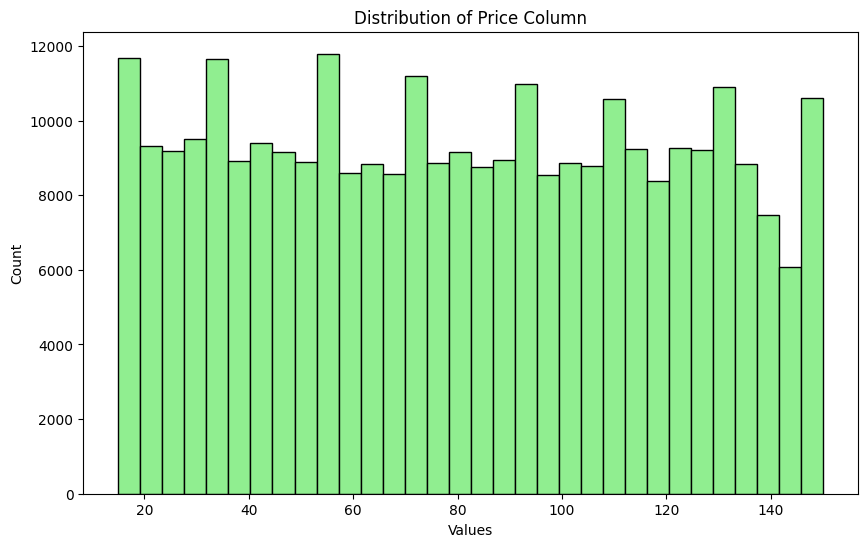

In [70]:
plt.figure(figsize=(10, 6))
plt.hist(train_imputed['round_price'], bins=32, color='lightgreen', edgecolor='black')
plt.title('Distribution of Price Column')
plt.xlabel('Values')
plt.ylabel('Count')
plt.show()

There is a weird pattern going on at most bin levels, where the initial bin has a higher than average count and the following 3-4 bars typically have a lower than average count. This may indicate that there are product tiers that structure the pricing, then add on features that increase the value over the base price. 

In [71]:
# create bar charts for each variable based on the brand column
brand_data = train_imputed.groupby(['Brand'])['round_price'].value_counts().reset_index()

brand_data

,Brand,round_price,count
0,Adidas,150,1025
1,Adidas,19,548
2,Adidas,34,547
3,Adidas,24,544
4,Adidas,44,539
...,...,...,...
675,Under Armour,145,274
676,Under Armour,146,260
677,Under Armour,148,251
678,Under Armour,147,234


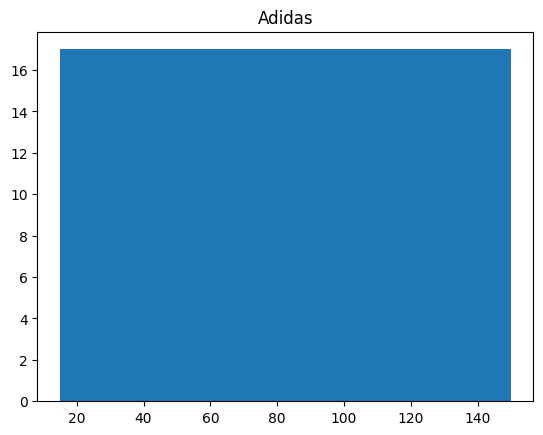

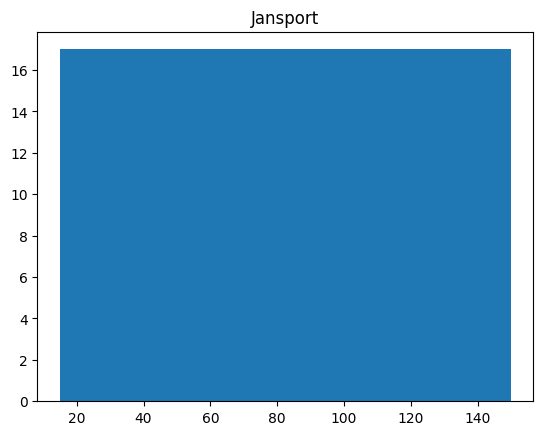

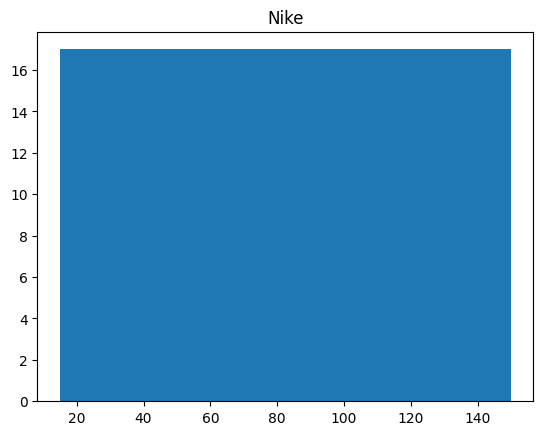

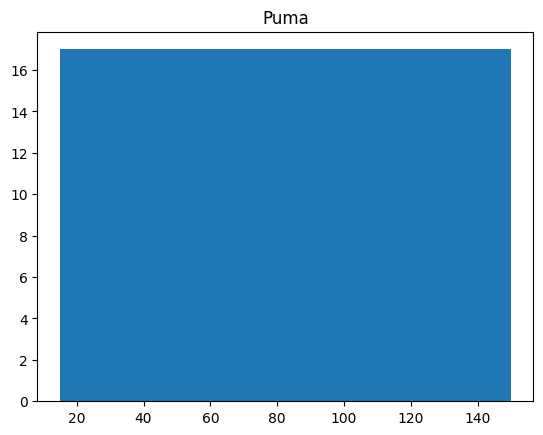

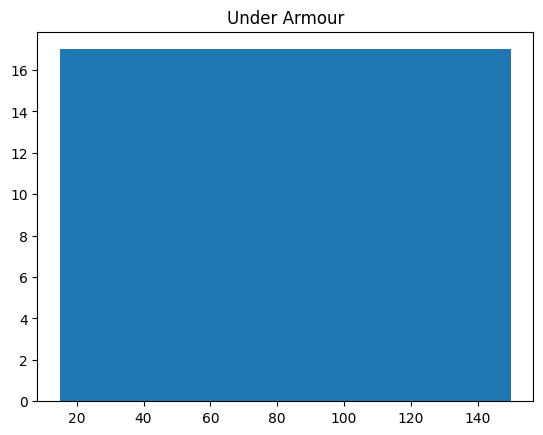

In [72]:
# plot binned histograms for each brand
for brand in brand_data['Brand'].unique():
    plt.hist(brand_data[brand_data['Brand'] == brand]['round_price'], bins=8)
    plt.title(brand)
    plt.show()

This shows that at 8 bins, each product has uniform distribution. This is interesting as it may indicate 8 distinct product with additional tarrifs and taxes. We will later engineer a price_tier feature based on 8 bins. 

#### Manufacturing features

Because the major costs that go into fabrication could be the materials used and the fabrication complexity. Let's look at # of compartments, size, style and materials as a function of price.

In [73]:
all_vars = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

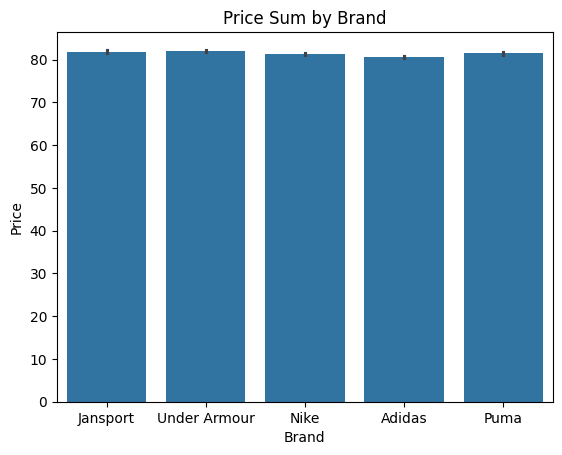

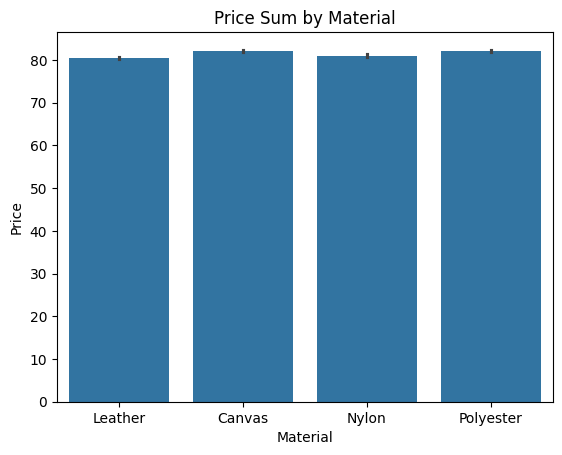

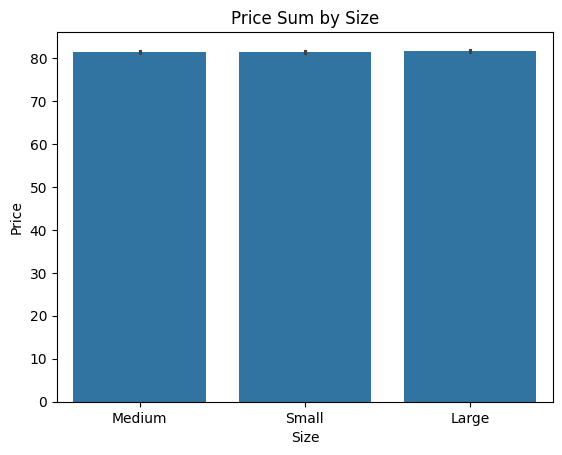

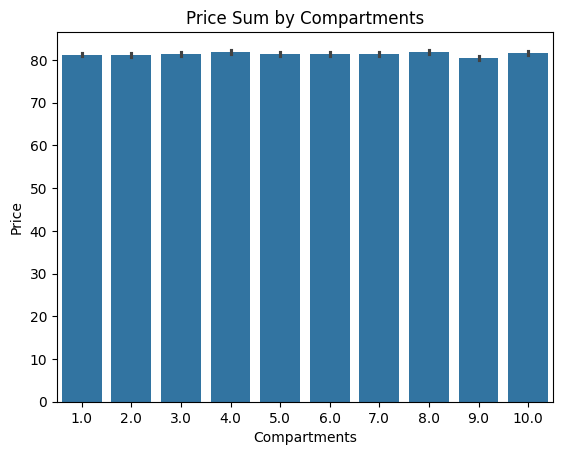

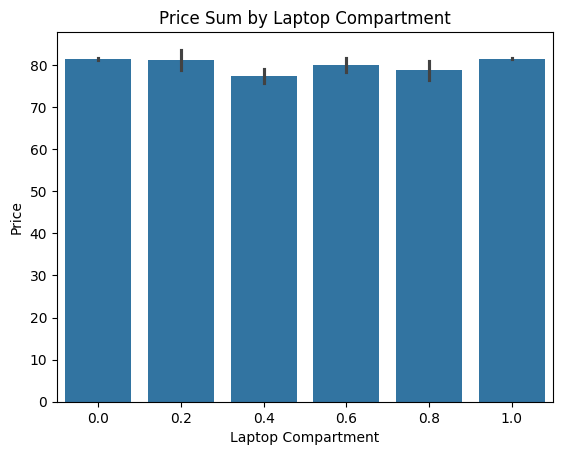

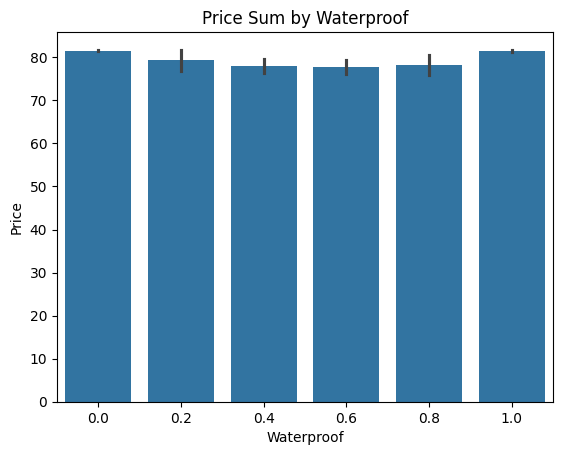

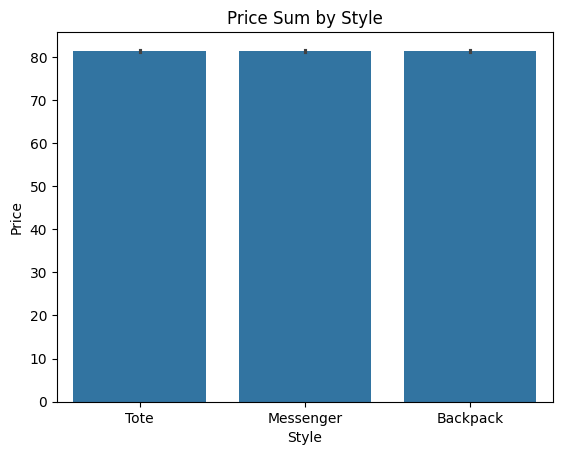

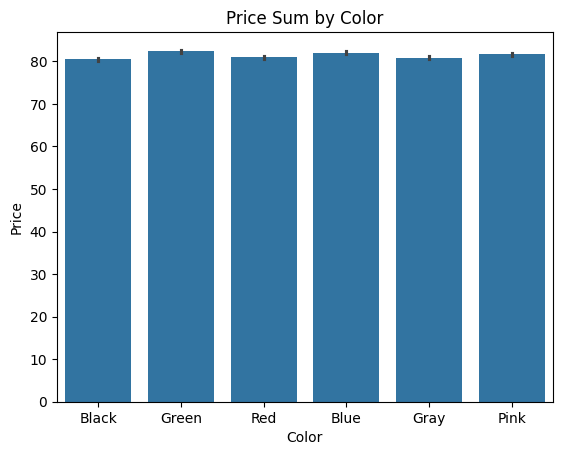

In [74]:
# # Create bar chart

for var in all_vars:
    sns.barplot(data=train_imputed, x=var, y='Price')
    plt.title(f'Price Sum by {var}')
    plt.show()



There isnt much variation between the categories, but perhaps creating some interaction terms leads to a better result. 

#### Weight Capacity Binning

In [75]:
# # plot binned histograms for each brand
# for brand in brand_data['Brand'].unique():
#     plt.hist(brand_data[brand_data['Brand'] == brand]['round_price'], bins=8)
#     plt.title(brand)
#     plt.show()

train_imputed['weight_capacity_rounded'] = train_imputed['Weight Capacity (kg)'].apply(lambda x: round(x))
print(train_imputed['weight_capacity_rounded'].min())
print(train_imputed['weight_capacity_rounded'].max())


5
30


['5.0 - 12.0', '12.0 - 18.0', '18.0 - 24.0', '24.0 - 30.0']


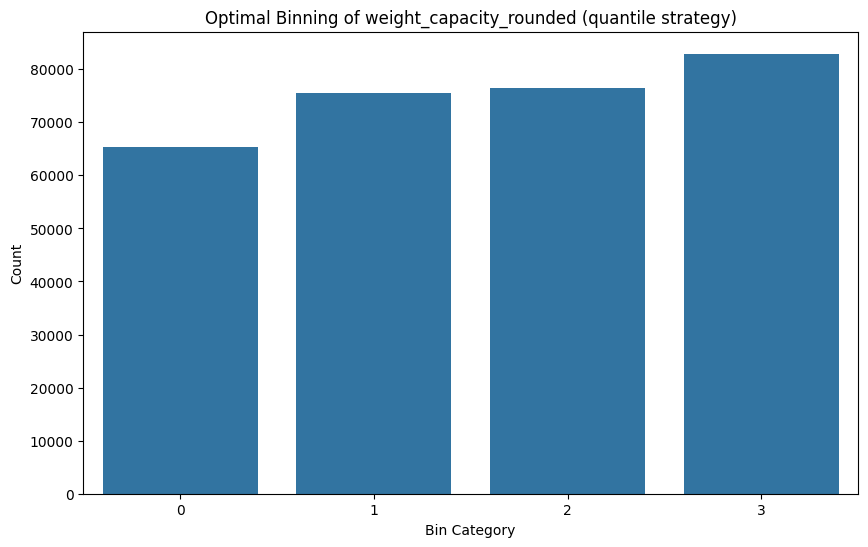

In [76]:
binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
binned_values = binner.fit_transform(train_imputed[['weight_capacity_rounded']]).astype(int).flatten()

# Create bin category column
bin_col_name = f"weight_capacity_rounded_binned"
train_imputed[bin_col_name] = binned_values

bin_edges = binner.bin_edges_[0]
bin_labels = [f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}" for i in range(len(bin_edges) - 1)]

print(bin_labels)

# Plot bin distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=pd.Series(binned_values).value_counts().sort_index().index, 
                y=pd.Series(binned_values).value_counts().sort_index().values)
plt.title(f'Optimal Binning of weight_capacity_rounded (quantile strategy)')
plt.xlabel('Bin Category')
plt.ylabel('Count')
plt.show()

After testing a number of different binning strategies, 4 bins seems reasonable covering 6kg per bin. 

In [77]:
train_imputed[bin_col_name].unique()

array([1, 3, 2, 0])

### Feature Engineering

In [78]:
def engineer_features(df, is_train_set=False):

    # first create price bins
    if is_train_set:
        df['round_price'] = df.Price.astype(int)
        binner = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
        binned_values = binner.fit_transform(df[['round_price']]).astype(int).flatten()

        # Create bin category column
        bin_col_name = f"price_cat"
        df[bin_col_name] = binned_values

    df['weight_capacity_rounded'] = df['Weight Capacity (kg)'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['brand_material'] = df['Brand'] + '_' + df['Material']
    df['brand_material'] = df['brand_material'].astype('category').cat.codes

    df['brand_size'] = df['Brand'] + '_' + df['Size']
    df['brand_size'] = df['brand_size'].astype('category').cat.codes

    df['style_size'] = df['Style'] + '_' + df['Size']
    df['style_size'] = df['style_size'].astype('category').cat.codes

    df['style_material'] = df['Style'] + '_' + df['Material']
    df['style_material'] = df['style_material'].astype('category').cat.codes

    df['color_material'] = df['Color'] + '_' + df['Material']
    df['color_material'] = df['color_material'].astype('category').cat.codes

    df['weight_capacity_ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    df['weight_to_compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.drop(columns=['brand', 'material', 'size', 'style', 'color'])

    df = df.rename({'Weight Capacity (kg)':'weight_capacity'})

    return df 

train_eng = engineer_features(train_imputed.copy(), True)
test_eng = engineer_features(test_imputed.copy())


enc_auto = TargetEncoder(smooth="auto")
train_eng['weight_capacity_ratio_enc'] = enc_auto.fit_transform(train_eng[['weight_capacity_ratio']], train_eng['price'])
test_eng['weight_capacity_ratio_enc'] = enc_auto.transform(test_eng[['weight_capacity_ratio']])

    

In [79]:
train_eng.head()

,id,compartments,laptop compartment,waterproof,weight capacity (kg),price,brand_enc,material_enc,size_enc,style_enc,...,weight_capacity_bins,brand_material,brand_size,style_size,style_material,color_material,weight_capacity_ratio,weight_to_compartments,compartments_bins,weight_capacity_ratio_enc
0,0,7.0,1.0,0.0,11.611723,112.15875,1.0,1.0,1.0,2.0,...,1,5,4,7,9,1,0.387057,1.451465,2,67.324706
1,1,10.0,1.0,1.0,27.078537,68.88056,1.0,0.0,2.0,1.0,...,3,4,5,5,4,12,0.902618,2.461685,2,81.387323
2,2,2.0,1.0,0.0,16.643760,39.17320,4.0,1.0,2.0,1.0,...,1,17,14,5,5,21,0.554792,5.547920,0,81.422596
3,3,8.0,1.0,0.0,12.937220,80.60793,2.0,2.0,2.0,1.0,...,1,10,8,5,6,14,0.431241,1.437469,2,81.379568
4,4,1.0,1.0,1.0,17.749338,86.02312,0.0,0.0,1.0,1.0,...,2,0,1,4,4,12,0.591645,8.874669,0,81.444248


### Scale data

In [80]:
train_eng.columns

Index(['id', 'compartments', 'laptop compartment', 'waterproof',
       'weight capacity (kg)', 'price', 'brand_enc', 'material_enc',
       'size_enc', 'style_enc', 'color_enc', 'round_price',
       'weight_capacity_rounded', 'weight_capacity_rounded_binned',
       'price_cat', 'weight_capacity_bins', 'brand_material', 'brand_size',
       'style_size', 'style_material', 'color_material',
       'weight_capacity_ratio', 'weight_to_compartments', 'compartments_bins',
       'weight_capacity_ratio_enc'],
      dtype='object')

In [91]:
X_cols = ['compartments', 'laptop compartment', 'waterproof',
       'weight capacity (kg)',  'brand_enc', 'material_enc',
       'size_enc', 'style_enc', 'color_enc', 'weight_capacity_rounded',
       'weight_capacity_bins', 'brand_material', 'brand_size', 'style_size',
       'style_material', 'color_material', 'weight_capacity_ratio',
       'weight_to_compartments', 'compartments_bins','weight_capacity_ratio_enc']

y_cols = ['price','price_cat','round_price']

In [92]:
# scale the test and train sets 

scaler = StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train_eng[X_cols]), columns=X_cols)
test_scaled = pd.DataFrame(scaler.transform(test_eng[X_cols]), columns=X_cols)


In [93]:
# add y cols back on
train_scaled[y_cols] = train_eng[y_cols]

In [94]:
train_scaled['log_price'] = np.log1p(train_scaled['price'])


### Model Training - Base Model

In [95]:
train_scaled.to_csv('data/train_scaled.csv', index=False)
test_scaled.to_csv('data/test_scaled.csv', index=False)

In [96]:
train_scaled = pd.read_csv('data/train_scaled.csv')
test_scaled = pd.read_csv('data/test_scaled.csv')

In [109]:
X = train_scaled[X_cols]
y = train_scaled['price']

In [110]:
def eval_xgb(xgb_params):
    # Setup K-Fold Cross-Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    best_score = float('inf')
    best_params = None

    model = None

    # Iterate over parameter combinations
    for params in ParameterGrid(xgb_params):
        scores = []
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train the model
            model = xgb.XGBRegressor(**params, objective='reg:squarederror')
            model.fit(X_train, y_train)
            
            # Evaluate on validation set
            preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, preds)
            scores.append(score)
        
        # Average score across folds
        avg_score = np.mean(scores)
        
        # Keep track of the best parameters
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    print("Best Parameters:", best_params)
    print("Best RMSE: {:.2f}%".format(best_score * 100))

    return model

In [111]:

# Parameter grids for each model
xgb_params = {
    'n_estimators': [ 10, 20, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,4,5]
}

lgb_params = {
    'n_estimators': [400, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.02],
    'num_leaves': [20, 30, 40]
}

cb_params = {
    'iterations': [150,200,250],
    'learning_rate': [0.1],
    'depth': [3]
}

rf_params = {
    'n_estimators': [300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

# Initialize the models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression', metric='rmse')
cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)


# Grid search setups
def run_grid_search(model, params, name, scoring='neg_root_mean_squared_error', X=X, y=y):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [112]:

print("Running GridSearch for XGBoost...")
best_xgb = eval_xgb(xgb_params)


Running GridSearch for XGBoost...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
Best RMSE: 3897.52%


In [113]:

print("Running GridSearch for LightGBM...")
best_lgb = run_grid_search(lgb_model, lgb_params, "LightGBM")

Running GridSearch for LightGBM...


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 20
[LightGBM] [Info] Start training from score 81.371595
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 20
[LightGBM] [Info] Start training from score 81.474306
[LightGBM] [Warning] Fou

In [114]:

print("Running GridSearch for CatBoost...")
best_cb = run_grid_search(cb_model, cb_params, "CatBoost")


Running GridSearch for CatBoost...
Best parameters for CatBoost: {'depth': 3, 'iterations': 250, 'learning_rate': 0.1}
Best score for CatBoost: 38.9729716471127


In [122]:
test_scaled['price_1'] = best_xgb.predict(test_scaled[X_cols])
test_scaled['price_2'] = best_lgb.predict(test_scaled[X_cols])
test_scaled['price_3'] = best_cb.predict(test_scaled[X_cols])

test_scaled['price'] = (test_scaled['price_1'] + test_scaled['price_2'] + test_scaled['price_3']) / 3

# de log the price
#test_scaled['price'] = np.expm1(test_scaled['price'])

In [125]:
create_submission_file(test_scaled)

,id,Price
0,300000,83.080665
1,300001,82.610610


#### Feature Importance for Cat Boost Regressor

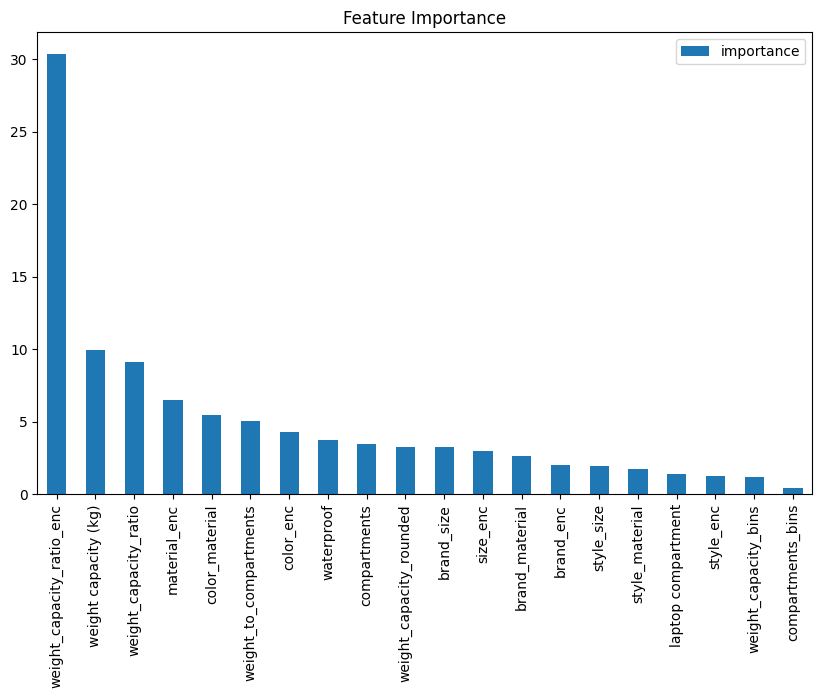

In [117]:
#plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_cb.feature_importances_, index=X_cols, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [118]:
from scipy.optimize import minimize


def find_optimal_weights(best_xgb, best_cb, best_lgb, X_val, y_val):
    """
    Find optimal weights for ensemble predictions of three models.

    Parameters:
    - best_xgb: Trained XGBoost model
    - best_cb: Trained CatBoost model
    - best_lgb: Trained LightGBM model
    - X_val: Validation feature set (numpy array or DataFrame)
    - y_val: True target values (numpy array or Series)

    Returns:
    - Optimal weights as a numpy array
    """
    # Get model predictions
    preds_xgb = best_xgb.predict(X_val)
    preds_cb = best_cb.predict(X_val)
    preds_lgb = best_lgb.predict(X_val)
    
    # Combine predictions into a matrix
    preds_matrix = np.column_stack((preds_xgb, preds_cb, preds_lgb))

    # Define the objective function (MSE)
    def objective(weights):
        # Ensure the weights sum to 1
        weights = np.array(weights)
        weights /= np.sum(weights)
        # Weighted ensemble prediction
        ensemble_preds = np.dot(preds_matrix, weights)
        return np.mean((ensemble_preds - y_val) ** 2)

    # Initial weights (equal distribution)
    initial_weights = [1/3, 1/3, 1/3]

    # Constraints: weights must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds for weights: each between 0 and 1
    bounds = [(0, 1) for _ in range(3)]

    # Minimize the objective function
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

In [119]:
find_optimal_weights(best_xgb, best_cb, best_lgb, X, y)

array([1.00000000e+00, 1.19182442e-13, 2.50355292e-14])